# Goals

This notebook will map pout the burr pipelines that we will use to do document ingestion

## ENV Variables

In [1]:
# set your OpenAI API key
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

## Ingestion Flow DAG  

At this high level we will include:
- monitor: find new files
- validation: they are unique with a has
- ingest: move to raw stortage
- index: add to database


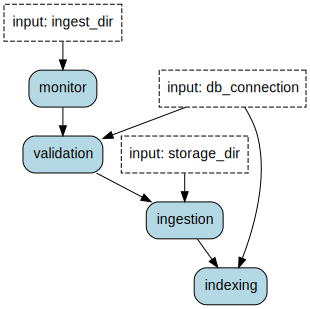

In [13]:
import pathlib
from burr.core import State, action, ApplicationBuilder

from ragnostic import utils

@action(reads=[], writes=["ingestion_status","ingestion_filepaths"])
def monitor(state: State, ingest_dir: str) -> State:
    """Checks if directory has files to ingest"""
    file_paths = []
    # Check filepath is valid
    path = pathlib.Path(ingest_dir)
    if (path.exists()) and (path.is_dir()):
        for p in path.iterdir():
            if p.suffix in ['.PDF','.pdf']:
                file_paths.append(str(p.resolve()))
        ingestion_status = "ingesting"
    else:
        #log status error
        ingestion_status="completed"
    
    return state.update(
        ingestion_status=ingestion_status, 
        ingestion_filepaths=file_paths
    )

@action(reads=["ingestion_filepaths"], writes=["valid_filepaths","invalid_filepaths"])
def validation(state: State, db_connection:str) -> State:
    """Check which files in the ingestion list are valid
    - not duplicates, etc.
    """
    valid_filepaths = []
    invalid_filepaths = []

    for filepath in state.get("ingestion_filepaths"):
        # Check duplicates
        # check with hash against the database?
        # - other checks?
        is_valid=True

        #move to list
        if is_valid:
            valid_filepaths.append(filepath)
        else:
            invalid_filepaths.append(filepath)

    return state.update(
        valid_filepaths=valid_filepaths, 
        invalid_filepaths=invalid_filepaths,
    )


@action(reads=["valid_filepaths"], writes=["successful_docs","failed_docs"])
def ingestion(state: State, storage_dir: str) -> State:
    """Process a batch of documents, tracking successes and failures."""
    
    filepaths = state.get("valid_filepaths")
    successful = []
    failed = []
    
    for p in filepaths:
        
        # Move file to new location
        copy_result = utils.copy_file(src_path=p, dest_dir=storage_dir)
        if not copy_result.success:
            failed.append((p, copy_result.error_code))
            continue
        # Generate new document ID and filename
        doc_id = utils.create_doc_id(prefix="DOC")
        suffix = pathlib.Path(p).suffix
        doc_filename = f"{doc_id}{suffix}"
        # Rename with document ID
        rename_result = utils.rename_file(file_path=copy_result.filepath, new_name=doc_filename)
        if not rename_result.success:
            failed.append((src_file, rename_result.error_code))
            continue
        successful.append(rename_result.filepath)
    
    return state.update(successful_docs=successful, failed_docs=failed)

@action(reads=["successful_docs"], writes=["ingestion_status"])
def indexing(state: State, db_connection: str) -> State:
    """Update database with succesfully ingested docs"""
    successful = state.get("successful_docs")

    # Update database with all document ids
    # - primary key is document id
    # - filepath is storage path
    # - should we add metadata here? put a status for further processing?
    ingestion_status = "Completed"
    return state.update(ingestion_status=ingestion_status)


# Build and visualize graph/logic
(
    ApplicationBuilder()
    .with_actions(monitor, validation, ingestion, indexing)
    .with_transitions(
        ("monitor", "validation"),
        ("validation", "ingestion"),
        ("ingestion", "indexing"),
    )
    .with_entrypoint("monitor")
    .build()
)